###Install Library and preparing

In [1]:
!pip install -q torch
!pip install -q tf
!pip install -q gdown
!pip install -q transformers[torch] accelerate -U
!pip install -q accelerate -U
!pip install -q datasets
!pip install -q gensim
!pip install -q evaluate

###Import Library

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import re
import gc
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report
from collections import Counter
import tensorflow as tf
from gensim.models import Word2Vec
from transformers import AutoTokenizer, AutoModelForSequenceClassification,Trainer, AutoConfig, TrainingArguments, EarlyStoppingCallback
from tensorflow.keras.layers import Input, Embedding, Conv1D, GlobalMaxPooling1D, MaxPooling1D, Dense, Flatten, concatenate, BatchNormalization,LSTM, Dropout, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import backend as K
from datasets import load_dataset
import evaluate
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import he_normal
from sklearn.model_selection import StratifiedKFold
import csv
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import BorderlineSMOTE, KMeansSMOTE, SVMSMOTE

import os
os.environ["WANDB_DISABLED"] = "true"

###Read Dataset and load Word2Vec

In [4]:
df = pd.read_csv("/content/hoax_train_balanced_clean.csv")

In [5]:
df_test1 = pd.read_csv("/content/hoax_test_clean.csv")

In [6]:
df.head()

,Text,Label
0,rakyat ga pernah hutang listrik tapi pln rugi ...,1
1,di media sosial beredar unggahan video yang di...,1
2,terkuak sudah mantan napi ex kasus juddol,1
3,gerik kita gampang untuk dipantau.,1
4,benarkah ini kawan....??? apa penyebab penyaki...,1


In [7]:
df.shape

(22938, 2)

In [8]:
print(df['Label'].value_counts())

Label
1    11469
0    11469
Name: count, dtype: int64


In [9]:
import gensim
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
gc.collect()
print(gensim.__version__)
# Load Pretrained Word Embeddings (Word2Vec)
# !gdown --id 1QYj5FruufaPq2mZgC6lZlq2Uw2E004Og
# !gdown --id 1F9QsHO7FPIPq3nL_I0zCkZFvq3OVcJrB
# !gdown --id 1VUjxpH10baOw439V-YAAVVbtyI8iLgG5

4.4.0


In [10]:
import os
import shutil
import zipfile
import gdown
from google.colab import drive

drive_zip_name = 'model_w2v.zip'
drive_path = f'/content/drive/MyDrive/model_w2v/{drive_zip_name}'

file_id = '1R0Rq2oQEH4N1K7eXLvGkvKosR2rzxIw3'
url = f'https://drive.google.com/uc?id={file_id}'

final_model_name = 'idwiki_word2vec_768_new_lower.model'

if os.path.exists(final_model_name):
    print("Model is Available")

else:
    if not os.path.exists('/content/drive'):
        try:
            drive.mount('/content/drive')
        except:
            pass

    if os.path.exists(drive_path):
        shutil.copy(drive_path, '/content/model_w2v.zip')
    else:
        try:
            gdown.download(url, 'model_w2v.zip', quiet=False)
        except Exception as e:
            raise e

    # Extract
    if os.path.exists('model_w2v.zip'):
        print("Extracting...")
        with zipfile.ZipFile('model_w2v.zip', 'r') as zip_ref:
            zip_ref.extractall('/content/')

# Load Model
if os.path.exists(final_model_name):
    model = Word2Vec.load(final_model_name)
else:
    print("Failed")

Model is Available


In [11]:
word_embeddings = Word2Vec.load('/content/idwiki_word2vec_768_new_lower.model')
#word_embeddings = Word2Vec.load('/content/modelword2vec/idwiki_word2vec_768_new_lower.model')

###Split Dataset

In [12]:
x_train = df['Text']
y_train = df['Label']

In [13]:
x_test1 = df_test1['Text']
y_test1 = np.array(df_test1['Label'])

###Define Loss Function, Tokenization, Word Embeddings and Oversampling

In [14]:
# # Define the margin loss function
# def margin_loss(y_true, y_pred):
#     margin = K.constant(0.1)
#     y_true_float = K.cast(y_true, dtype='float32')  # Convert y_true to float32
#     squared_difference_pos = K.square(K.maximum(0.9 - y_pred, 0))
#     squared_difference_neg = K.square(K.maximum(y_pred - 0.1, 0))
#     loss_pos = K.mean(y_true_float * squared_difference_pos)
#     loss_neg = K.mean((1 - y_true_float) * squared_difference_neg)
#     total_loss = loss_pos + lambda_val * loss_neg
#     return total_loss

In [15]:
# # # Define the model architectures
# # #embedding_dim = 300
# # #max_sequence_length = 100
# lambda_val = 0.7  # Lambda value for margin loss
# # #num_words = 100000

In [16]:
# Create word index
word_index = {word: index + 1 for index, word in enumerate(word_embeddings.wv.index_to_key)}

# Create embedding matrix
embedding_dim = word_embeddings.vector_size
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
for word, i in word_index.items():
    if word in word_embeddings.wv:
        embedding_vector = word_embeddings.wv[word]
        embedding_matrix[i] = embedding_vector


In [17]:
tokenizer = Tokenizer(num_words=len(word_index) + 1, oov_token='<OOV>')
tokenizer.fit_on_texts(x_train.astype(str).fillna(''))

# Convert text to sequences and pad
x_train_sequences = tokenizer.texts_to_sequences(x_train.astype(str).fillna(''))
x_test_sequences1 = tokenizer.texts_to_sequences(x_test1.astype(str).fillna(''))
# x_test_sequences2 = tokenizer.texts_to_sequences(x_test2)
# x_test_sequences3 = tokenizer.texts_to_sequences(x_test3)

# Determine max sequence length based on your data
max_sequence_length = max(max(len(seq) for seq in x_train_sequences), max(len(seq) for seq in x_test_sequences1))

x_train_padded = pad_sequences(x_train_sequences, maxlen=max_sequence_length, padding='post')
x_test_padded1 = pad_sequences(x_test_sequences1, maxlen=max_sequence_length, padding='post')
# x_test_padded2 = pad_sequences(x_test_sequences2, maxlen=max_sequence_length, padding='post')
# x_test_padded3 = pad_sequences(x_test_sequences3, maxlen=max_sequence_length, padding='post')


In [18]:
x_train_flat = x_train_padded.reshape(x_train_padded.shape[0], -1)

####Oversampling with BorderlineSMOTE

In [19]:
borderline_smote = BorderlineSMOTE(random_state=42)
x_train_resampled_flat_borderline, y_train_resampled_borderline = borderline_smote.fit_resample(x_train_flat, y_train)
x_train_resampled_borderline = x_train_resampled_flat_borderline.reshape(x_train_resampled_flat_borderline.shape[0], max_sequence_length)

####Oversampling with KMeansSMOTE

In [20]:
kmeans_smote = KMeansSMOTE(random_state=42, cluster_balance_threshold=0.2)
x_train_resampled_flat_kmeans, y_train_resampled_kmeans = kmeans_smote.fit_resample(x_train_flat, y_train)
x_train_resampled_kmeans = x_train_resampled_flat_kmeans.reshape(x_train_resampled_flat_kmeans.shape[0], max_sequence_length)

####Oversampling with SVMSMOTE

In [21]:
svm_smote = SVMSMOTE(random_state=42)
x_train_resampled_flat_svm, y_train_resampled_svm = svm_smote.fit_resample(x_train_flat, y_train)
x_train_resampled_svm = x_train_resampled_flat_svm.reshape(x_train_resampled_flat_svm.shape[0], max_sequence_length)

In [22]:
torch.cuda.empty_cache()
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [23]:
from google.colab import drive
drive.flush_and_unmount()

Drive not mounted, so nothing to flush and unmount.


##CNN Model

In [24]:
# Define the architecture of the static model with he_normal initialization
static_input = Input(shape=(max_sequence_length,))
static_embedding = Embedding(len(word_index) + 1, embedding_dim, input_length=max_sequence_length, trainable=False)(static_input)  # Removed weights parameter

#Convolutional Layers
static_cnn_output = Conv1D(128, 3, activation='relu', kernel_initializer=he_normal())(static_embedding)  # Use he_normal initialization
static_cnn_output = MaxPooling1D(2)(static_cnn_output)
static_cnn_output = GlobalMaxPooling1D()(static_cnn_output)
static_cnn_output = Dropout(0.5)(static_cnn_output)
batch_norm_layer = BatchNormalization()(static_cnn_output)

#Fully Connected Layers
static_dense_output = Dense(128, activation='relu', kernel_initializer=he_normal())(batch_norm_layer)  # Use he_normal initialization
static_dense_output = Dropout(0.5)(static_dense_output)
output = Dense(1, activation='sigmoid')(static_dense_output)

# Create the static model
static_model = Model(inputs=static_input, outputs=output)
static_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Early stopping callback
early_stopping = EarlyStopping(patience=3, restore_best_weights=True)

###CNN BorderlineSMOTE Train and Test

In [25]:
# Train the static model
epochs_static = 10
history_static = static_model.fit(
    x_train_resampled_borderline,
    y_train_resampled_borderline,
    batch_size=32,
    epochs=epochs_static,
    validation_split=0.1,
    callbacks=[early_stopping],
)



Epoch 1/10
646/646 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - accuracy: 0.7993 - loss: 0.4382 - val_accuracy: 0.9843 - val_loss: 0.0603
Epoch 2/10
646/646 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.9668 - loss: 0.0932 - val_accuracy: 0.9996 - val_loss: 0.0106
Epoch 3/10
646/646 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.9790 - loss: 0.0589 - val_accuracy: 0.9969 - val_loss: 0.0118
Epoch 4/10
646/646 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.9827 - loss: 0.0512 - val_accuracy: 0.9987 - val_loss: 0.0073
Epoch 5/10
646/646 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.9874 - loss: 0.0392 - val_accuracy: 0.9983 - val_loss: 0.0051
Epoch 6/10
646/646 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.9870 - loss: 0.0357 - val_accuracy: 1.0000 - val_loss: 0.0024
Epoch 7/10
646/646 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.9900 - loss: 0.0271 - val_accuracy: 0.9996 - val_loss: 0.0027
Epoch 8/10
646/646 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.9882 - loss: 0.0358 - val_accuracy: 

####Testing

In [26]:
# Evaluate the static model
if len(y_test1.shape) == 1:
    y_test1_reshaped = np.expand_dims(y_test1, axis=-1)
else:
    y_test1_reshaped = y_test1

static_evaluation1 = static_model.evaluate(x_test_padded1, y_test1_reshaped, batch_size=32)
static_accuracy1 = static_evaluation1[1]

print("Static Model Evaluation Results:")
print("Accuracy:", static_accuracy1)

51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8762 - loss: 0.6013
Static Model Evaluation Results:
Accuracy: 0.8739913105964661


In [27]:
y_test_pred1 = (static_model.predict(x_test_padded1) > 0.5).astype("int32").flatten()

test_report1 = classification_report(y_test1, y_test_pred1)

print("Classification Report on Test Dataset 1 :")
print(test_report1)

51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
Classification Report on Test Dataset 1 :
              precision    recall  f1-score   support

           0       0.99      0.40      0.57       336
           1       0.86      1.00      0.93      1275

    accuracy                           0.87      1611
   macro avg       0.93      0.70      0.75      1611
weighted avg       0.89      0.87      0.85      1611



###CNN KmeansSMOTE Train and Test

In [29]:
# Create the static model
static_model = Model(inputs=static_input, outputs=output)
static_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [30]:
# Train the static model
epochs_static = 10
history_static_kmeans = static_model.fit(
    x_train_resampled_kmeans,
    y_train_resampled_kmeans,
    batch_size=32,
    epochs=epochs_static,
    validation_split=0.1,
    callbacks=[early_stopping],
)



Epoch 1/10
646/646 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - accuracy: 0.9922 - loss: 0.0224 - val_accuracy: 1.0000 - val_loss: 5.9231e-04
Epoch 2/10
646/646 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.9932 - loss: 0.0199 - val_accuracy: 1.0000 - val_loss: 6.2159e-04
Epoch 3/10
646/646 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.9932 - loss: 0.0196 - val_accuracy: 0.9996 - val_loss: 0.0014
Epoch 4/10
646/646 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.9931 - loss: 0.0210 - val_accuracy: 1.0000 - val_loss: 0.0010


####Testing

In [31]:
# Evaluate the static model
if len(y_test1.shape) == 1:
    y_test1_reshaped = np.expand_dims(y_test1, axis=-1)
else:
    y_test1_reshaped = y_test1

static_evaluation1 = static_model.evaluate(x_test_padded1, y_test1_reshaped, batch_size=32)
static_accuracy1 = static_evaluation1[1]

print("Static Model Evaluation Results:")
print("Accuracy:", static_accuracy1)

51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8998 - loss: 0.4351
Static Model Evaluation Results:
Accuracy: 0.8932340145111084


In [32]:
y_test_pred_BL = (static_model.predict(x_test_padded1) > 0.5).astype("int32").flatten()

test_report1 = classification_report(y_test1, y_test_pred_BL)

print("Classification Report on Test Dataset 1 :")
print(test_report1)

51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
Classification Report on Test Dataset 1 :
              precision    recall  f1-score   support

           0       0.98      0.50      0.66       336
           1       0.88      1.00      0.94      1275

    accuracy                           0.89      1611
   macro avg       0.93      0.75      0.80      1611
weighted avg       0.90      0.89      0.88      1611



In [33]:
# Run garbage collection
gc.collect()

1314

###CNN SVMSMOTE Train and Test

In [34]:
# Create the static model
static_model = Model(inputs=static_input, outputs=output)
static_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [35]:
# Train the static model
epochs_static = 10
history_static_svm = static_model.fit(
    x_train_resampled_svm,
    y_train_resampled_svm,
    batch_size=32,
    epochs=epochs_static,
    validation_split=0.1,
    callbacks=[early_stopping],
)



Epoch 1/10
646/646 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - accuracy: 0.9927 - loss: 0.0219 - val_accuracy: 1.0000 - val_loss: 5.7164e-04
Epoch 2/10
646/646 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.9923 - loss: 0.0216 - val_accuracy: 1.0000 - val_loss: 5.1329e-04
Epoch 3/10
646/646 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.9928 - loss: 0.0232 - val_accuracy: 1.0000 - val_loss: 8.4676e-04
Epoch 4/10
646/646 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.9937 - loss: 0.0179 - val_accuracy: 1.0000 - val_loss: 1.8987e-04
Epoch 5/10
646/646 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.9939 - loss: 0.0162 - val_accuracy: 1.0000 - val_loss: 2.0941e-04
Epoch 6/10
646/646 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.9945 - loss: 0.0168 - val_accuracy: 1.0000 - val_loss: 4.4662e-04
Epoch 7/10
646/646 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.9960 - loss: 0.0108 - val_accuracy: 1.0000 - val_loss: 8.8246e-05
Epoch 8/10
646/646 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.9960 - l

####Testing

In [36]:
# Evaluate the static model
if len(y_test1.shape) == 1:
    y_test1_reshaped = np.expand_dims(y_test1, axis=-1)
else:
    y_test1_reshaped = y_test1

static_evaluation1 = static_model.evaluate(x_test_padded1, y_test1_reshaped, batch_size=32)
static_accuracy1 = static_evaluation1[1]

print("Static Model Evaluation Results:")
print("Accuracy:", static_accuracy1)

51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8933 - loss: 0.5424
Static Model Evaluation Results:
Accuracy: 0.8919925689697266


In [37]:
y_test_pred_KM = (static_model.predict(x_test_padded1) > 0.5).astype("int32").flatten()

test_report1 = classification_report(y_test1, y_test_pred_KM)

print("Classification Report on Test Dataset 1 :")
print(test_report1)

51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
Classification Report on Test Dataset 1 :
              precision    recall  f1-score   support

           0       0.99      0.49      0.65       336
           1       0.88      1.00      0.94      1275

    accuracy                           0.89      1611
   macro avg       0.94      0.74      0.79      1611
weighted avg       0.90      0.89      0.88      1611



##Evaluation

In [38]:
torch.cuda.empty_cache()

In [39]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.model_selection import KFold
import seaborn as sns
import matplotlib.pyplot as plt

def show_confusion_matrix(confusion_matrix):
        hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
        hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
        hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')

        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')

###CNN

####BorderlineSMOTE

51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


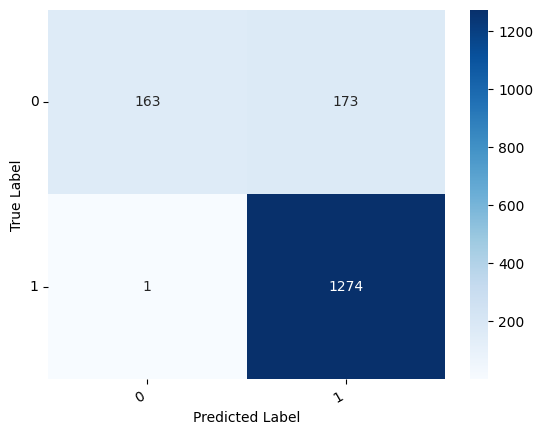

In [40]:
predictions_static_BL = static_model.predict(x_test_padded1)
predicted_labels_static_1 = (predictions_static_BL > 0.5).astype(int)
cm_static_BL = confusion_matrix(y_test1,predicted_labels_static_1)
show_confusion_matrix(cm_static_BL)

####KMeansSMOTE

51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


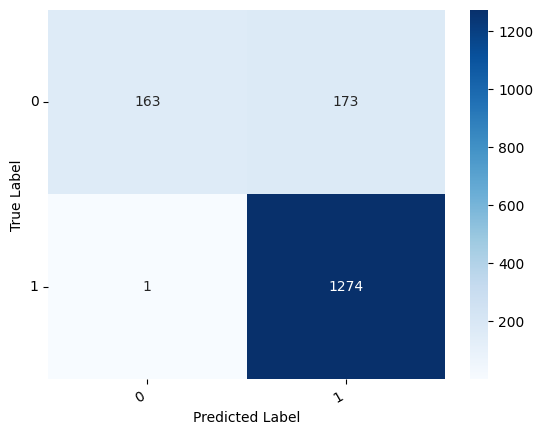

In [41]:
predictions_static_KM = static_model.predict(x_test_padded1)
predicted_labels_static_1 = (predictions_static_KM > 0.5).astype(int)
cm_static_KM = confusion_matrix(y_test1,predicted_labels_static_1)
show_confusion_matrix(cm_static_KM)

####SVMSMOTE

51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


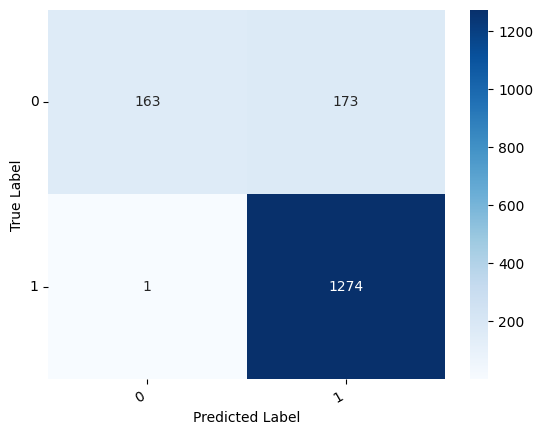

In [42]:
predictions_static_SVM = static_model.predict(x_test_padded1)
predicted_labels_static_1 = (predictions_static_SVM > 0.5).astype(int)
cm_static_SVM = confusion_matrix(y_test1,predicted_labels_static_1)
show_confusion_matrix(cm_static_SVM)